In [41]:
PROC IMPORT DATAFILE = "all_patients_CLEANED.csv" out=all_patients1 DBMS=CSV; RUN;

In [42]:
DATA all_patients;
    SET all_patients1;
    randomobs=ranuni(1);
RUN;

In [43]:
proc export data=all_patients
   outfile='all_patients1.csv'
   dbms=csv
   replace;
run;

In [2]:
%macro sample(list,thelast, ds);
DATA t(RENAME=(ptid=tptid)) c(RENAME=(ptid=cptid));
   SET all_patients; 
   IF trt="T" THEN OUTPUT t;
      ELSE IF trt="C" THEN OUTPUT c;
   KEEP ptid randomobs &list &thelast; 
run;
PROC SORT DATA=t; BY &list &thelast randomobs; run;
PROC SORT DATA=c; BY &list &thelast randomobs; run;

DATA c;
   SET c; BY &list &thelast;
   IF FIRST.&thelast THEN observe=0;
     observe+1;
run;
PROC SORT; BY &list &thelast observe; run;

DATA t;
   SET t; BY &list &thelast;
   IF FIRST.&thelast THEN observe=0;
     observe+1;
run;
PROC SORT; BY &list &thelast observe; run;

DATA both;
   MERGE t(IN=int) c(IN=inc); BY &list &thelast observe;
   IF int AND inc;
run;

DATA t(RENAME=(tptid=ptid) DROP=cptid) c(RENAME=(cptid=ptid) DROP=tptid);
   SET both; 
   DROP &list &thelast randomobs observe; 
run;

PROC SORT DATA=t; BY ptid; run;
PROC SORT DATA=c; BY ptid; run;
PROC SORT DATA=all_patients; BY ptid; run;

DATA final_patients;
    MERGE all_patients(IN=in1) t(IN=int) c(IN=inc); BY ptid;
	IF (in1 AND int) OR (in1 AND inc);
run;

DATA &ds; SET final_patients; RUN;
%mend;

In [3]:
%macro themodel(dataset, dep, indep=, title=, by=);
	PROC glm data=&dataset; 
		BY &by;
		CLASS trt age_grp age_grp2 gender region state year newvar store;
		MODEL &dep = &indep / solution;
		LSMEANS trt / pdiff=controlu CL stderr cov out=adjmeans;
		TITLE "&title";
	run;
%mend;

In [4]:
%sample(age_grp 	gender month pre_product_vol store newvar, state, aggspvstm_n); 

In [5]:
DATA finalpt;
   SET aggspvstm_n; 
   IF preprod=1 THEN pp="N";
      ELSE pp="Y";
RUN;


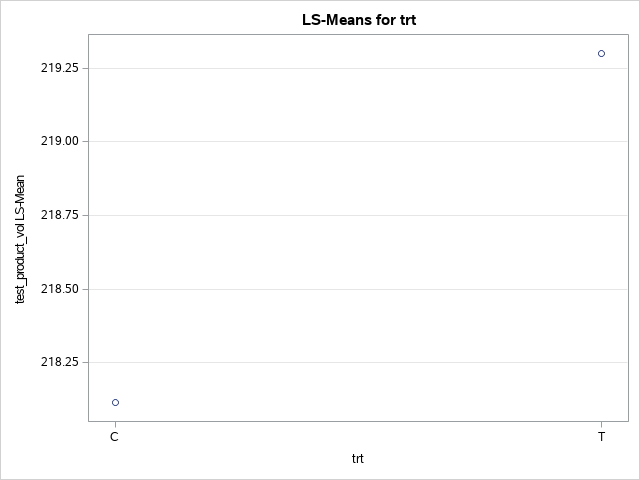
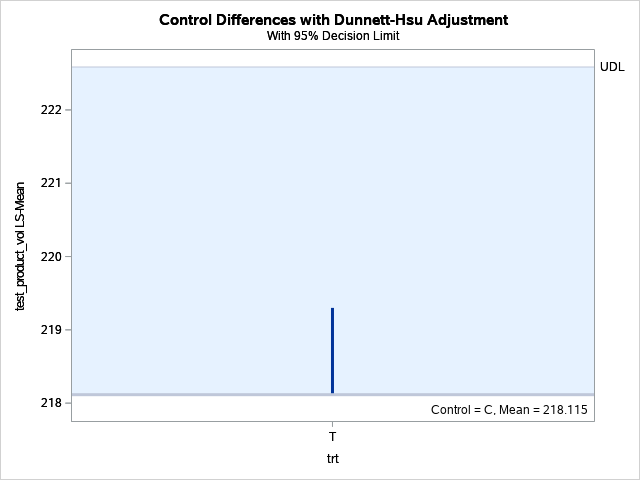

In [6]:
%themodel(all_patients, test_product_vol, indep = trt pre_product_vol age gender month state rf_num, 
          title=Adjusted Qty Results for Matched Sample);

In [ ]:
%macro genmod(ds=,byes=,indep=,dep=);
    
	PROC SORT DATA=&ds; BY &byes trt; run;
    
	PROC UNIVARIATE DATA=&ds noprint;
		BY &byes trt;
		VAR &dep;
		OUTPUT OUT=means  mean=mean n=n;
	run;
	PROC SORT DATA=&ds; BY &byes; run;   
    
	PROC GENMOD DATA=&ds; 
		BY &byes;
		CLASS trt age_grp age_grp2 gender region state year store;
		MODEL &dep=trt &indep / dist=normal type3 wald scale=deviance;
		LSMEANS trt/diffs cov;
		ODS OUTPUT parameterestimates=sol lsmeans = lsmeans diffs = diffs;
		run;
	run;
%mend

In [14]:
%macro genmod1(ds=,byes=,indep=,dep=);
    
	PROC SORT DATA=&ds; BY &byes trt; run;
    
	PROC UNIVARIATE DATA=&ds noprint;
		BY &byes trt;
		VAR &dep;
		OUTPUT OUT=means  mean=mean n=n;
	run;
	PROC SORT DATA=&ds; BY &byes; run;   
    
	PROC GENMOD DATA=&ds; 
		BY &byes;
		CLASS trt age_grp age_grp2 gender region state year store;
		MODEL &dep=trt &indep / dist=normal
		run;
	run;
%mend

In [19]:
PROC IMPORT DATAFILE = "finalpt.csv" out=finalpt2 DBMS=CSV; RUN;

In [17]:
%genmod1(ds=finalpt,byes=all, indep=pre_product_vol age gender month state rf_num, dep=test_product_vol);   

In [ ]:
%macro genmodnew(ds=,byes=,indep=,dep=);
    ods select none;
	PROC SORT DATA=&ds; BY &byes trt; run;
    
	PROC UNIVARIATE DATA=&ds noprint;
		BY &byes trt;
		VAR &dep;
		OUTPUT OUT=means  mean=mean n=n;
	run;
	PROC SORT DATA=&ds; BY &byes; run;   
    
	PROC GENMOD DATA=&ds; 
		BY &byes;
		CLASS trt age_grp age_grp2 gender region state year store;
		MODEL &dep=trt &indep / dist=normal type3 wald scale=deviance;
		LSMEANS trt/diffs cov;
		ODS OUTPUT parameterestimates=sol lsmeans = lsmeans diffs = diffs;
		run; quit;
		ODS select all;
		ODS show;
	run;
    
	DATA meanlist(drop=diff effect trt);
		LENGTH impact_star $12;
		MERGE means(WHERE=(trt='T') RENAME=(mean=meant n=nt) )
        means(WHERE=(trt='C') RENAME=(mean=meanc n=nc) )
        lsmeans(KEEP=&byes effect trt estimate stderr WHERE=(trt='T') RENAME=(estimate=lsmeant stderr=se_lst))
        lsmeans(KEEP=&byes effect trt estimate stderr WHERE=(trt='C') RENAME=(estimate=lsmeanc stderr=se_lsc))
        diffs(drop=trt _trt rename=(estimate=diff stderr=se_diff));
		BY &byes;
		Impact=-diff;
		LowerCL=Impact-1.282*se_diff; 
		UpperCL=Impact+1.282*se_diff;
		IF se_diff>0 THEN T=Impact/se_diff;
         ELSE t=0;
		probt=1-probnorm(t);
		%*formchar(probt,pval);
		IF probt<.01 THEN star='***';
			ELSE IF probt<.05 THEN star=' **';
			ELSE IF probt<.10 THEN star='  *';
			ELSE IF probt<.20 THEN star='  +';
			Impact_star=right(put(impact,6.2))||' '||left(star);
			dep="&dep";
			confidence=1-probt;
			FORMAT nt nc 6. meant meanc lsmeant lsmeanc impact diff 6.4 ;
			LABEL meanc='Mean~Comparison'                meant='Mean~Test'
            lsmeant='LS Mean~Test'                 lsmeanc='LS Mean~Comparison'
            Impact='Impact~(LS Mean Difference)'   Impact_star='Impact~Pvalue'
            nt='N~Test'                            nc='N~Comparison'
            se_diff='Impact~Std Error'             star='Significance: ***=.01  **=.05    *=.20'
            se_lst='Std Error~LS Mean~Test'        se_lsc='Std Error~LS Mean~Comparison';
%mend
        

In [ ]:
%genmodnew(ds=finalpt,byes=all, indep=pre_product_vol age gender month state rf_num,dep=test_product_vol);   

In [ ]:
proc export data=meanAA1a
   outfile='meanAA1a.csv'
   dbms=csv
   replace;
run;

In [ ]:
proc export data=c
   outfile='c_new.csv'
   dbms=csv
   replace;
run;